В данном ноутбуке код ничем не отличает от кода в PHD_punctuation_analysis.ipynb. Только исправлен файл phd.py на phd_qwen.py для работы с моделью `Qwen1.5B`. Внутри него были также отредактированы функции, так как в отличие от RoBERTa, Qwen не использует [CLS]/[SEP] токены, которые обрезались в первоначальном варианте функций.

---

In [ ]:
!pip install scikit-dimension
!pip install jsonlines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week')

In [ ]:
import skdim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import torch
import nltk
from plotly.subplots import make_subplots
from phd_qwen import get_phd, get_raw_phd, get_embeds, get_raw_phd_in_loop
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import modeling_utils
if not hasattr(modeling_utils, "ALL_PARALLEL_STYLES") or modeling_utils.ALL_PARALLEL_STYLES is None:
    modeling_utils.ALL_PARALLEL_STYLES = ["tp", "none", "colwise", 'rowwise']

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import jsonlines
import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/data/en_train.jsonl'

data = []
with jsonlines.open(file_path, 'r') as reader:
    for obj in reader:
        data.append(obj)

df = pd.DataFrame(data)
df.head()

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...


In [ ]:
def get_embeds_and_tokens(df):
    embeds_list = []
    tokens_list = []
    embeds_list_text = []
    tokens_list_text = []
    for i in tqdm(range(2, 50, 2)):
        text = ''.join(df['text'].values.tolist()[i:(i + 1)])
        embeds, tokens = get_embeds(text[:2000], returns_tokenized=True)
        embeds_list.extend(embeds)
        tokens_list.extend(tokens)
        embeds_list_text.append(embeds)
        tokens_list_text.append(tokens)

    return embeds_list, tokens_list, embeds_list_text, tokens_list_text

In [ ]:
MIN_TOKENS = 47

In [ ]:
def plot_phd_comparison(pos_tags, per_text_vals, global_vals, title):
    """
    pos_tags: список POS
    per_text_vals: словарь {POS: значение} — per-text
    global_vals: словарь {POS: значение} — global
    title: заголовок графика
    """
    data = {
        'Per-text mean': [per_text_vals.get(pos, None) for pos in pos_tags],
        'Global':        [global_vals.get(pos, None) for pos in pos_tags],
    }

    df = pd.DataFrame(data, index=pos_tags)
    df.plot(kind='bar', rot=0)
    plt.title(title)
    plt.ylabel('PHD')
    plt.xlabel('Part of Speech')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def print_phd_mle_counts(counter_dict, title=""):
    """
    Выводит таблицу с количеством применений PHD и MLE по каждой POS.

    Аргументы:
    - counter_dict: словарь {POS: {'phd': int, 'mle': int}}
    - title: необязательный заголовок
    """
    df = pd.DataFrame.from_dict(counter_dict, orient='index')
    df = df.rename(columns={'phd': 'PHD count', 'mle': 'MLE count'})
    df['Total'] = df['PHD count'] + df['MLE count']
    df = df.sort_values(by='Total', ascending=False)

    if title:
        print(f"\n=== {title} ===")

    display(df.style.bar(subset=['PHD count', 'MLE count'], color='#5fba7d').format("{:.0f}"))


from skdim.id import MLE

def mle_estimate_phd(embeds_sub, k=5):
    """
    Оценивает внутреннюю размерность (в духе PHD) с помощью MLE-метода Левины–Бикеля

    Аргументы:
    - embeds_sub: np.ndarray формы (n_points, embedding_dim) — эмбеддинги токенов
    - k: int — число ближайших соседей (по умолчанию 5)

    Возвращает:
    - float — оценка размерности manifold (MLE-интерпретация PHD)
    """
    embeds_sub = np.array(embeds_sub)
    if embeds_sub.ndim != 2:
        raise ValueError("embeds_sub должен быть 2D массивом: (n_points, embedding_dim)")

    if embeds_sub.shape[0] <= k:
        raise ValueError(f"Слишком мало токенов ({embeds_sub.shape[0]}), нужно хотя бы k+1={k+1}")

    model = MLE(K=k)
    dim = model.fit_transform(embeds_sub)

    return float(dim)

In [ ]:
def compute_phd_by_pos_per_text(tokens_list, embeds_list, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD отдельно по каждой POS в каждом тексте,
    затем усредняет по всем текстам.

    Если POS < min_tokens, то fallback на MLE.

    Возвращает:
    - словарь {pos_tag: [list of phd values]} — для boxplot
    - словарь {pos_tag: float} — среднее значение по всем текстам
    - счётчики использования: {pos_tag: {'phd': int, 'mle': int}}
    """
    pos2phd_all = {pos: [] for pos in pos_tags}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for tokens, embeds in tqdm(zip(tokens_list, embeds_list)):
        tagged = nltk.pos_tag(tokens, tagset='universal')
        df = pd.DataFrame(tagged, columns=['token', 'pos'])
        df['embed'] = list(embeds)

        for pos in pos_tags:
            df_sub = df[df['pos'] == pos]
            embeds_sub = np.array(df_sub['embed'].tolist())

            try:
                if len(df_sub) >= min_tokens:
                    norm = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                    phd = np.mean(get_raw_phd_in_loop(norm, n_tries=5))
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['phd'] += 1
                else:
                    phd = mle_estimate_phd(embeds_sub)
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['mle'] += 1
            except Exception as e:
                print(f"💥 compute_phd_by_pos_per_text — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
                continue

    pos2phd_mean = {pos: np.mean(vals) for pos, vals in pos2phd_all.items() if len(vals) > 0}
    return pos2phd_all, pos2phd_mean, pos2count


def compute_phd_without_pos_per_text(tokens_list, embeds_list, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD по всем токенам кроме заданного POS (поочерёдно),
    затем усредняет по всем текстам.

    Если POS-исключённый набор < min_tokens, то fallback на MLE.

    Возвращает:
    - словарь {pos_tag: [list of phd values]} — для boxplot
    - словарь {pos_tag: float} — среднее значение
    - счётчики использования: {pos_tag: {'phd': int, 'mle': int}}
    """
    pos2phd_all = {pos: [] for pos in pos_tags}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for tokens, embeds in tqdm(zip(tokens_list, embeds_list)):
        tagged = nltk.pos_tag(tokens, tagset='universal')
        df = pd.DataFrame(tagged, columns=['token', 'pos'])
        df['embed'] = list(embeds)

        for pos in pos_tags:
            df_sub = df[df['pos'] != pos]
            embeds_sub = np.array(df_sub['embed'].tolist())

            try:
                if len(df_sub) >= min_tokens:
                    norm = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                    phd = np.mean(get_raw_phd_in_loop(norm, n_tries=5))
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['phd'] += 1
                else:
                    phd = mle_estimate_phd(embeds_sub)
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['mle'] += 1
            except Exception as e:
                print(f"💥 compute_phd_without_pos_per_text — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
                continue

    pos2phd_mean = {pos: np.mean(vals) for pos, vals in pos2phd_all.items() if len(vals) > 0}
    return pos2phd_all, pos2phd_mean, pos2count


def compute_phd_by_pos_global(tokens, embeds, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD отдельно по каждой POS в глобальном (pooled) стиле.
    Если токенов мало, применяет MLE.

    Возвращает:
    - словарь {pos_tag: phd_value}
    - счётчики {pos_tag: {'phd': int, 'mle': int}}
    """
    tagged = nltk.pos_tag(tokens, tagset='universal')
    df = pd.DataFrame(tagged, columns=['token', 'pos'])
    df['embed'] = list(embeds)

    pos2phd = {}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for pos in tqdm(pos_tags):
        df_sub = df[df['pos'] == pos]
        embeds_sub = np.array(df_sub['embed'].tolist())

        try:
            if len(df_sub) >= min_tokens:
                normed = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                phd = np.mean(get_raw_phd_in_loop(normed, n_tries=5))
                pos2phd[pos] = phd
                pos2count[pos]['phd'] += 1
            else:
                phd = mle_estimate_phd(embeds_sub)
                pos2phd[pos] = phd
                pos2count[pos]['mle'] += 1
        except Exception as e:
            print(f"💥 compute_phd_by_pos_global — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
            continue

    return pos2phd, pos2count


def compute_phd_without_pos_global(tokens, embeds, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD по всем токенам, КРОМЕ заданной части речи (поочерёдно).
    Если токенов после исключения слишком мало, применяет MLE.

    Возвращает:
    - словарь {pos_tag: phd_value}
    - счётчики {pos_tag: {'phd': int, 'mle': int}}
    """
    tagged = nltk.pos_tag(tokens, tagset='universal')
    df = pd.DataFrame(tagged, columns=['token', 'pos'])
    df['embed'] = list(embeds)

    pos2phd = {}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for pos in tqdm(pos_tags):
        df_sub = df[df['pos'] != pos]
        embeds_sub = np.array(df_sub['embed'].tolist())

        try:
            if len(df_sub) >= min_tokens:
                normed = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                phd = np.mean(get_raw_phd_in_loop(normed, n_tries=5))
                pos2phd[pos] = phd
                pos2count[pos]['phd'] += 1
            else:
                phd = mle_estimate_phd(embeds_sub)
                pos2phd[pos] = phd
                pos2count[pos]['mle'] += 1
        except Exception as e:
            print(f"💥 compute_phd_without_pos_global — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
            continue


    return pos2phd, pos2count


In [ ]:
pos_tags = ['NOUN', '.', 'VERB', 'ADJ']

embeds_llm, tokens_llm, embeds_llm_text, tokens_llm_text = get_embeds_and_tokens(df.query("label == 1"))
embeds_human, tokens_human, embeds_human_text, tokens_human_text = get_embeds_and_tokens(df.query("label == 0"))

100%|██████████| 24/24 [01:16<00:00,  3.17s/it]


In [12]:
# --- LLM ---
phd_llm_global_pos, count_llm_global = compute_phd_by_pos_global(tokens_llm, embeds_llm, pos_tags)
phd_llm_global_wo, count_llm_global_wo = compute_phd_without_pos_global(tokens_llm, embeds_llm, pos_tags)

phd_llm_all, phd_llm_pertext_mean, count_llm = compute_phd_by_pos_per_text(tokens_llm_text, embeds_llm_text, pos_tags)
phd_llm_all_wo, phd_llm_pertext_wo_mean, count_llm_wo = compute_phd_without_pos_per_text(tokens_llm_text, embeds_llm_text, pos_tags)

  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  3369 point_jump =  475
input_shape: (3369, 2048)
mn_points =  40 max_points =  3369 point_jump =  475
input_shape: (3369, 2048)
mn_points =  40 max_points =  3369 point_jump =  475
input_shape: (3369, 2048)
mn_points =  40 max_points =  3369 point_jump =  475
input_shape: (3369, 2048)
mn_points =  40 max_points =  3369 point_jump =  475
input_shape: (3369, 2048)


 25%|██▌       | 1/4 [11:44<35:12, 704.08s/it]

mn_points =  40 max_points =  528 point_jump =  69
input_shape: (528, 2048)
mn_points =  40 max_points =  528 point_jump =  69
input_shape: (528, 2048)
mn_points =  40 max_points =  528 point_jump =  69
input_shape: (528, 2048)
mn_points =  40 max_points =  528 point_jump =  69
input_shape: (528, 2048)
mn_points =  40 max_points =  528 point_jump =  69
input_shape: (528, 2048)


 50%|█████     | 2/4 [11:58<09:56, 298.26s/it]

mn_points =  40 max_points =  770 point_jump =  104
input_shape: (770, 2048)
mn_points =  40 max_points =  770 point_jump =  104
input_shape: (770, 2048)
mn_points =  40 max_points =  770 point_jump =  104
input_shape: (770, 2048)
mn_points =  40 max_points =  770 point_jump =  104
input_shape: (770, 2048)
mn_points =  40 max_points =  770 point_jump =  104
input_shape: (770, 2048)


 75%|███████▌  | 3/4 [12:28<02:55, 175.84s/it]

mn_points =  40 max_points =  713 point_jump =  96
input_shape: (713, 2048)
mn_points =  40 max_points =  713 point_jump =  96
input_shape: (713, 2048)
mn_points =  40 max_points =  713 point_jump =  96
input_shape: (713, 2048)
mn_points =  40 max_points =  713 point_jump =  96
input_shape: (713, 2048)
mn_points =  40 max_points =  713 point_jump =  96
input_shape: (713, 2048)


  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  2523 point_jump =  354
input_shape: (2523, 2048)
mn_points =  40 max_points =  2523 point_jump =  354
input_shape: (2523, 2048)
mn_points =  40 max_points =  2523 point_jump =  354
input_shape: (2523, 2048)
mn_points =  40 max_points =  2523 point_jump =  354
input_shape: (2523, 2048)
mn_points =  40 max_points =  2523 point_jump =  354
input_shape: (2523, 2048)


 25%|██▌       | 1/4 [06:25<19:17, 385.68s/it]

mn_points =  40 max_points =  5364 point_jump =  760
input_shape: (5364, 2048)
mn_points =  40 max_points =  5364 point_jump =  760
input_shape: (5364, 2048)
mn_points =  40 max_points =  5364 point_jump =  760
input_shape: (5364, 2048)
mn_points =  40 max_points =  5364 point_jump =  760
input_shape: (5364, 2048)
mn_points =  40 max_points =  5364 point_jump =  760
input_shape: (5364, 2048)


 50%|█████     | 2/4 [35:29<39:29, 1184.69s/it]

mn_points =  40 max_points =  5122 point_jump =  726
input_shape: (5122, 2048)
mn_points =  40 max_points =  5122 point_jump =  726
input_shape: (5122, 2048)
mn_points =  40 max_points =  5122 point_jump =  726
input_shape: (5122, 2048)
mn_points =  40 max_points =  5122 point_jump =  726
input_shape: (5122, 2048)
mn_points =  40 max_points =  5122 point_jump =  726
input_shape: (5122, 2048)


 75%|███████▌  | 3/4 [53:52<19:07, 1147.53s/it]

mn_points =  40 max_points =  5179 point_jump =  734
input_shape: (5179, 2048)
mn_points =  40 max_points =  5179 point_jump =  734
input_shape: (5179, 2048)
mn_points =  40 max_points =  5179 point_jump =  734
input_shape: (5179, 2048)
mn_points =  40 max_points =  5179 point_jump =  734
input_shape: (5179, 2048)
mn_points =  40 max_points =  5179 point_jump =  734
input_shape: (5179, 2048)


100%|██████████| 4/4 [1:20:28<00:00, 1207.20s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  274 point_jump =  33
input_shape: (274, 2048)
mn_points =  40 max_points =  274 point_jump =  33
input_shape: (274, 2048)
mn_points =  40 max_points =  274 point_jump =  33
input_shape: (274, 2048)
mn_points =  40 max_points =  274 point_jump =  33
input_shape: (274, 2048)
mn_points =  40 max_points =  274 point_jump =  33
input_shape: (274, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 poi

1it [00:05,  5.22s/it]

mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 2048)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 2048)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 2048)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 2048)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 poi

2it [00:09,  4.78s/it]

mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 poi

3it [00:13,  4.34s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)


4it [00:14,  2.87s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 2048)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 2048)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 2048)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 2048)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)


6it [00:16,  2.07s/it]

mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 2048)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 2048)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 2048)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 2048)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 poi

7it [00:20,  2.58s/it]

💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 4, ошибка: Слишком мало токенов (4), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 2048)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 2048)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 2048)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 2048)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)


9it [00:24,  2.34s/it]

mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 2048)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 2048)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 2048)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 2048)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 2048)


10it [00:25,  2.04s/it]

mn_points =  40 max_points =  185 point_jump =  20
input_shape: (185, 2048)
mn_points =  40 max_points =  185 point_jump =  20
input_shape: (185, 2048)
mn_points =  40 max_points =  185 point_jump =  20
input_shape: (185, 2048)
mn_points =  40 max_points =  185 point_jump =  20
input_shape: (185, 2048)
mn_points =  40 max_points =  185 point_jump =  20
input_shape: (185, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)


11it [00:28,  2.23s/it]

mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 2048)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 2048)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 2048)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 2048)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 2048)


12it [00:29,  1.88s/it]

mn_points =  40 max_points =  89 point_jump =  7
input_shape: (89, 2048)
mn_points =  40 max_points =  89 point_jump =  7
input_shape: (89, 2048)
mn_points =  40 max_points =  89 point_jump =  7
input_shape: (89, 2048)
mn_points =  40 max_points =  89 point_jump =  7
input_shape: (89, 2048)


13it [00:30,  1.59s/it]

mn_points =  40 max_points =  89 point_jump =  7
input_shape: (89, 2048)
💥 compute_phd_by_pos_per_text — POS: ., токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_j

16it [00:34,  1.54s/it]

mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  291 point_jump =  35
input_shape: (291, 2048)
mn_points =  40 max_points =  291 point_jump =  35
input_shape: (291, 2048)
mn_points =  40 max_points =  291 point_jump =  35
input_shape: (291, 2048)
mn_points =  40 max_points =  291 point_jump =  35
input_shape: (291, 2048)
mn_points =  40 max_points =  291 point_jump =  35
input_shape: (291, 2048)


17it [00:40,  2.27s/it]

mn_points =  40 max_points =  217 point_jump =  25
input_shape: (217, 2048)
mn_points =  40 max_points =  217 point_jump =  25
input_shape: (217, 2048)
mn_points =  40 max_points =  217 point_jump =  25
input_shape: (217, 2048)
mn_points =  40 max_points =  217 point_jump =  25
input_shape: (217, 2048)
mn_points =  40 max_points =  217 point_jump =  25
input_shape: (217, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)


18it [00:43,  2.58s/it]

mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 2048)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 2048)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 2048)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 2048)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 2048)


19it [00:46,  2.53s/it]

mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 poi

20it [00:50,  2.91s/it]

mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)


21it [00:51,  2.46s/it]

💥 compute_phd_by_pos_per_text — POS: ., токенов: 3, ошибка: Слишком мало токенов (3), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 4, ошибка: Слишком мало токенов (4), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 1, ошибка: Слишком мало токенов (1), нужно хотя бы k+1=6
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)


24it [00:51,  2.17s/it]


mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6


0it [00:00, ?it/s]

mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 2048)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 2048)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 2048)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 2048)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 2048)
mn_points =  40 max_points =  468 point_jump =  61
input_shape: (468, 2048)
mn_points =  40 max_points =  468 point_jump =  61
input_shape: (468, 2048)
mn_points =  40 max_points =  468 point_jump =  61
input_shape: (468, 2048)
mn_points =  40 max_points =  468 point_jump =  61
input_shape: (468, 2048)
mn_points =  40 max_points =  468 point_jump =  61
input_shape: (468, 2048)
mn_points =  40 max_points =  444 point_jump =  57
input_shape: (444, 2048)
mn_points =  40 max_points =  444 point_jump =  57
input_shape: (444, 2048)
mn_points =  40 max_points =  444 point_jump =  57
input_shape: (444, 2048)
mn_points = 

1it [00:35, 35.33s/it]

mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 2048)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 2048)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 2048)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 2048)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 2048)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 2048)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 2048)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 2048)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 2048)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 2048)
mn_points =  40 max_points =  356 point_jump =  45
input_shape: (356, 2048)
mn_points =  40 max_points =  356 point_jump =  45
input_shape: (356, 2048)
mn_points =  40 max_points =  356 point_jump =  45
input_shape: (356, 2048)
mn_points = 

2it [00:59, 28.56s/it]

mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  330 point_jump =  41
input_shape: (330, 2048)
mn_points =  40 max_points =  330 point_jump =  41
input_shape: (330, 2048)
mn_points =  40 max_points =  330 point_jump =  41
input_shape: (330, 2048)
mn_points =  40 max_points =  330 point_jump =  41
input_shape: (330, 2048)
mn_points =  40 max_points =  330 point_jump =  41
input_shape: (330, 2048)
mn_points =  40 max_points =  310 point_jump =  38
input_shape: (310, 2048)
mn_points =  40 max_points =  310 point_jump =  38
input_shape: (310, 2048)
mn_points =  40 max_points =  310 point_jump =  38
input_shape: (310, 2048)
mn_points = 

3it [01:18, 24.35s/it]

mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 2048)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 2048)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 2048)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 2048)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 2048)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 2048)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 2048)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 2048)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 2048)
mn_points =  40 max_points =  101 p

4it [01:22, 16.28s/it]

mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
in

5it [01:24, 11.29s/it]

mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 2048)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 2048)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 2048)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 2048)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 2048)
mn_points =  40 max_points =  313 point_jump =  39
input_shape: (313, 2048)
mn_points =  40 max_points =  313 point_jump =  39
input_shape: (313, 2048)
mn_points =  40 max_points =  313 point_jump =  39
input_shape: (313, 2048)
mn_points =  40 max_points =  313 point_jump =  39
input_shape: (313, 2048)
mn_points =  40 max_points =  313 point_jump =  39
input_shape: (313, 2048)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 2048)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 2048)
mn_points =  40

6it [01:37, 11.82s/it]

mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 2048)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 2048)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 2048)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 2048)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 2048)
mn_points =  40 max_points =  307 point_jump =  38
input_shape: (307, 2048)
mn_points =  40 max_points =  307 point_jump =  38
input_shape: (307, 2048)
mn_points =  40 max_points =  307 point_jump =  38
input_shape: (307, 2048)
mn_points = 

7it [01:55, 13.80s/it]

mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
in

8it [01:57,  9.94s/it]

mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 2048)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 2048)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 2048)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 2048)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 2048)
mn_points =  40 max_points =  355 point_jump =  45
input_shape: (355, 2048)
mn_points =  40 max_points =  355 point_jump =  45
input_shape: (355, 2048)
mn_points =  40

9it [02:17, 13.13s/it]

mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 2048)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 2048)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 2048)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 2048)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 2048)
mn_points =  40 max_points 

10it [02:23, 11.00s/it]

mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 2048)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 2048)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 2048)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 2048)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 2048)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 2048)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 2048)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 2048)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 2048)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 2048)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 2048)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 2048)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 2048)
mn_points = 

11it [02:44, 14.07s/it]

mn_points =  40 max_points =  110 point_jump =  10
input_shape: (110, 2048)
mn_points =  40 max_points =  110 point_jump =  10
input_shape: (110, 2048)
mn_points =  40 max_points =  110 point_jump =  10
input_shape: (110, 2048)
mn_points =  40 max_points =  110 point_jump =  10
input_shape: (110, 2048)
mn_points =  40 max_points =  110 point_jump =  10
input_shape: (110, 2048)
mn_points =  40 max_points =  107 point_jump =  9
input_shape: (107, 2048)
mn_points =  40 max_points =  107 point_jump =  9
input_shape: (107, 2048)
mn_points =  40 max_points =  107 point_jump =  9
input_shape: (107, 2048)
mn_points =  40 max_points =  107 point_jump =  9
input_shape: (107, 2048)
mn_points =  40 max_points =  107 point_jump =  9
input_shape: (107, 2048)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 m

12it [02:48, 10.81s/it]

mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 2048)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 2048)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 2048)
mn_points =  40 max_points 

13it [02:53,  9.34s/it]

mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  58 point_jump =  2
in

15it [02:55,  5.48s/it]

mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  376 point_jump =  48
input_shape: (376, 2048)
mn_points =  40 max_points =  376 point_jump =  48
input_shape: (376, 2048)
mn_points =  40 max_points =  376 point_jump =  48
input_shape: (376, 2048)
mn_points =  40 max_points =  376 point_jump =  48
input_shape: (376, 2048)
mn_points =  40 max_points =  376 point_jump =  48
input_shape: (376, 2048)
mn_points =  40 max_points =  362 point_jump =  46
input_shape: (362, 2048)
mn_points =  40 max_points =  362 point_jump =  46
input_shape: (362, 2048)
mn_points =  40

16it [03:18,  9.60s/it]

mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  396 point_jump =  50
input_shape: (396, 2048)
mn_points =  40 max_points =  396 point_jump =  50
input_shape: (396, 2048)
mn_points =  40 max_points =  396 point_jump =  50
input_shape: (396, 2048)
mn_points =  40 max_points =  396 point_jump =  50
input_shape: (396, 2048)
mn_points =  40 max_points =  396 point_jump =  50
input_shape: (396, 2048)
mn_points =  40 max_points =  390 point_jump =  50
input_shape: (390, 2048)
mn_points =  40 max_points =  390 point_jump =  50
input_shape: (390, 2048)
mn_points =  40 max_points =  390 point_jump =  50
input_shape: (390, 2048)
mn_points = 

17it [03:43, 13.67s/it]

mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 2048)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 2048)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 2048)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 2048)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 2048)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 2048)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 2048)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 2048)
mn_points = 

18it [04:03, 15.36s/it]

mn_points =  40 max_points =  122 point_jump =  11
input_shape: (122, 2048)
mn_points =  40 max_points =  122 point_jump =  11
input_shape: (122, 2048)
mn_points =  40 max_points =  122 point_jump =  11
input_shape: (122, 2048)
mn_points =  40 max_points =  122 point_jump =  11
input_shape: (122, 2048)
mn_points =  40 max_points =  122 point_jump =  11
input_shape: (122, 2048)
mn_points =  40 max_points =  277 point_jump =  33
input_shape: (277, 2048)
mn_points =  40 max_points =  277 point_jump =  33
input_shape: (277, 2048)
mn_points =  40 max_points =  277 point_jump =  33
input_shape: (277, 2048)
mn_points =  40 max_points =  277 point_jump =  33
input_shape: (277, 2048)
mn_points =  40 max_points =  277 point_jump =  33
input_shape: (277, 2048)
mn_points =  40 max_points =  271 point_jump =  33
input_shape: (271, 2048)
mn_points =  40 max_points =  271 point_jump =  33
input_shape: (271, 2048)
mn_points =  40 max_points =  271 point_jump =  33
input_shape: (271, 2048)
mn_points = 

19it [04:15, 14.45s/it]

mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  160 point_jump =  17
input_shape: (160, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 2048)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 2048)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 2048)
mn_points = 

20it [04:34, 15.95s/it]

mn_points =  40 max_points =  86 point_jump =  6
input_shape: (86, 2048)
mn_points =  40 max_points =  86 point_jump =  6
input_shape: (86, 2048)
mn_points =  40 max_points =  86 point_jump =  6
input_shape: (86, 2048)
mn_points =  40 max_points =  86 point_jump =  6
input_shape: (86, 2048)
mn_points =  40 max_points =  86 point_jump =  6
input_shape: (86, 2048)
mn_points =  40 max_points =  187 point_jump =  21
input_shape: (187, 2048)
mn_points =  40 max_points =  187 point_jump =  21
input_shape: (187, 2048)
mn_points =  40 max_points =  187 point_jump =  21
input_shape: (187, 2048)
mn_points =  40 max_points =  187 point_jump =  21
input_shape: (187, 2048)
mn_points =  40 max_points =  187 point_jump =  21
input_shape: (187, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points 

21it [04:41, 13.29s/it]

mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 2048)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 2048)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 2048)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 2048)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 2048)
mn_points =  40 max_points =  93 point_jump =  7
input_shape: (93, 2048)
mn_points =  40 max_points =  93 point_jump =  7
input_shape: (93, 2048)
mn_points =  40 max_points =  93 point_jump =  7
input_shape: (93, 2048)
mn_points =  40 max_points =  93 point_jump =  7
input_shape: (93, 2048)
mn_points =  40 max_points =  93 point_jump =  7
input_shape: (93, 2048)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 2048)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 2048)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 2048)
mn_points =  40 max_points =  88 point_jump =  6
in

23it [04:44,  7.95s/it]

mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
in

24it [04:46, 11.95s/it]

mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)


In [13]:
# --- Human ---
phd_human_global_pos, count_human_global = compute_phd_by_pos_global(tokens_human, embeds_human, pos_tags)
phd_human_global_wo, count_human_global_wo = compute_phd_without_pos_global(tokens_human, embeds_human, pos_tags)

phd_human_all, phd_human_pertext_mean, count_human = compute_phd_by_pos_per_text(tokens_human_text, embeds_human_text, pos_tags)
phd_human_all_wo, phd_human_pertext_wo_mean, count_human_wo = compute_phd_without_pos_per_text(tokens_human_text, embeds_human_text, pos_tags)

  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  3186 point_jump =  449
input_shape: (3186, 2048)
mn_points =  40 max_points =  3186 point_jump =  449
input_shape: (3186, 2048)
mn_points =  40 max_points =  3186 point_jump =  449
input_shape: (3186, 2048)
mn_points =  40 max_points =  3186 point_jump =  449
input_shape: (3186, 2048)
mn_points =  40 max_points =  3186 point_jump =  449
input_shape: (3186, 2048)


 25%|██▌       | 1/4 [09:49<29:29, 589.80s/it]

mn_points =  40 max_points =  507 point_jump =  66
input_shape: (507, 2048)
mn_points =  40 max_points =  507 point_jump =  66
input_shape: (507, 2048)
mn_points =  40 max_points =  507 point_jump =  66
input_shape: (507, 2048)
mn_points =  40 max_points =  507 point_jump =  66
input_shape: (507, 2048)
mn_points =  40 max_points =  507 point_jump =  66
input_shape: (507, 2048)


 50%|█████     | 2/4 [10:02<08:20, 250.50s/it]

mn_points =  40 max_points =  736 point_jump =  99
input_shape: (736, 2048)
mn_points =  40 max_points =  736 point_jump =  99
input_shape: (736, 2048)
mn_points =  40 max_points =  736 point_jump =  99
input_shape: (736, 2048)
mn_points =  40 max_points =  736 point_jump =  99
input_shape: (736, 2048)
mn_points =  40 max_points =  736 point_jump =  99
input_shape: (736, 2048)


 75%|███████▌  | 3/4 [10:29<02:28, 148.48s/it]

mn_points =  40 max_points =  599 point_jump =  79
input_shape: (599, 2048)
mn_points =  40 max_points =  599 point_jump =  79
input_shape: (599, 2048)
mn_points =  40 max_points =  599 point_jump =  79
input_shape: (599, 2048)
mn_points =  40 max_points =  599 point_jump =  79
input_shape: (599, 2048)
mn_points =  40 max_points =  599 point_jump =  79
input_shape: (599, 2048)


  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  2334 point_jump =  327
input_shape: (2334, 2048)
mn_points =  40 max_points =  2334 point_jump =  327
input_shape: (2334, 2048)
mn_points =  40 max_points =  2334 point_jump =  327
input_shape: (2334, 2048)
mn_points =  40 max_points =  2334 point_jump =  327
input_shape: (2334, 2048)
mn_points =  40 max_points =  2334 point_jump =  327
input_shape: (2334, 2048)


 25%|██▌       | 1/4 [05:16<15:49, 316.35s/it]

mn_points =  40 max_points =  5013 point_jump =  710
input_shape: (5013, 2048)
mn_points =  40 max_points =  5013 point_jump =  710
input_shape: (5013, 2048)
mn_points =  40 max_points =  5013 point_jump =  710
input_shape: (5013, 2048)
mn_points =  40 max_points =  5013 point_jump =  710
input_shape: (5013, 2048)
mn_points =  40 max_points =  5013 point_jump =  710
input_shape: (5013, 2048)


 50%|█████     | 2/4 [29:59<33:24, 1002.47s/it]

mn_points =  40 max_points =  4784 point_jump =  677
input_shape: (4784, 2048)
mn_points =  40 max_points =  4784 point_jump =  677
input_shape: (4784, 2048)
mn_points =  40 max_points =  4784 point_jump =  677
input_shape: (4784, 2048)
mn_points =  40 max_points =  4784 point_jump =  677
input_shape: (4784, 2048)
mn_points =  40 max_points =  4784 point_jump =  677
input_shape: (4784, 2048)


 75%|███████▌  | 3/4 [52:30<19:21, 1161.92s/it]

mn_points =  40 max_points =  4921 point_jump =  697
input_shape: (4921, 2048)
mn_points =  40 max_points =  4921 point_jump =  697
input_shape: (4921, 2048)
mn_points =  40 max_points =  4921 point_jump =  697
input_shape: (4921, 2048)
mn_points =  40 max_points =  4921 point_jump =  697
input_shape: (4921, 2048)
mn_points =  40 max_points =  4921 point_jump =  697
input_shape: (4921, 2048)


100%|██████████| 4/4 [1:16:38<00:00, 1149.67s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 2048)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 2048)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 2048)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 2048)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 2048)


1it [00:01,  1.83s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)


2it [00:02,  1.11s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  216 point_jump =  25
input_shape: (216, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 2048)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 2048)
mn_points =  40 max_points =  54 poi

3it [00:06,  2.57s/it]

mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 2048)
mn_points =  40 max_points =  232 point_jump =  27
input_shape: (232, 2048)
mn_points =  40 max_points =  232 point_jump =  27
input_shape: (232, 2048)
mn_points =  40 max_points =  232 point_jump =  27
input_shape: (232, 2048)
mn_points =  40 max_points =  232 point_jump =  27
input_shape: (232, 2048)
mn_points =  40 max_points =  232 point_jump =  27
input_shape: (232, 2048)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 2048)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 2048)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 2048)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 2048)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 2048)
mn_points =  40 max_points =  63 point_jump =  3
input_shape: (63, 2048)
mn_points =  40 max_points =  63 point_jump =  3
input_shape: (63, 2048)
mn_points =  40 max_points =  63 poi

5it [00:11,  2.34s/it]

mn_points =  40 max_points =  63 point_jump =  3
input_shape: (63, 2048)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 2048)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 2048)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 2048)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 2048)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 2048)


7it [00:12,  1.59s/it]

mn_points =  40 max_points =  213 point_jump =  24
input_shape: (213, 2048)
mn_points =  40 max_points =  213 point_jump =  24
input_shape: (213, 2048)
mn_points =  40 max_points =  213 point_jump =  24
input_shape: (213, 2048)
mn_points =  40 max_points =  213 point_jump =  24
input_shape: (213, 2048)
mn_points =  40 max_points =  213 point_jump =  24
input_shape: (213, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)


8it [00:15,  2.04s/it]

mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 2048)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 2048)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 2048)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 2048)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 2048)
mn_points =  40 max_points =  51 poi

9it [00:19,  2.45s/it]

💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 4, ошибка: Слишком мало токенов (4), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 2, ошибка: Слишком мало токенов (2), нужно хотя бы k+1=6
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 2048)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 2048)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 2048)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 2048)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)


11it [00:21,  1.92s/it]

mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  74 point_jump =  4
input_shape: (74, 2048)
mn_points =  40 max_points =  74 point_jump =  4
input_shape: (74, 2048)
mn_points =  40 max_points =  74 point_jump =  4
input_shape: (74, 2048)
mn_points =  40 max_points =  74 point_jump =  4
input_shape: (74, 2048)
mn_points =  40 max_points =  74 point_jump =  4
input_shape: (74, 2048)


12it [00:22,  1.65s/it]

mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 2048)


13it [00:25,  1.86s/it]

mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)
mn_points =  40 max_points =  165 point_jump =  17
input_shape: (165, 2048)


14it [00:27,  1.93s/it]

mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)


15it [00:28,  1.77s/it]

mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 2048)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 2048)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 2048)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 2048)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 2048)


16it [00:30,  1.88s/it]

mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)
mn_points =  40 max_points =  179 point_jump =  19
input_shape: (179, 2048)


17it [00:33,  2.01s/it]

mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 2048)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 2048)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 2048)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 2048)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 2048)


18it [00:34,  1.98s/it]

mn_points =  40 max_points =  263 point_jump =  31
input_shape: (263, 2048)
mn_points =  40 max_points =  263 point_jump =  31
input_shape: (263, 2048)
mn_points =  40 max_points =  263 point_jump =  31
input_shape: (263, 2048)
mn_points =  40 max_points =  263 point_jump =  31
input_shape: (263, 2048)
mn_points =  40 max_points =  263 point_jump =  31
input_shape: (263, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
mn_points =  40 max_points =  48 poi

19it [00:39,  2.86s/it]

mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 2048)
💥 compute_phd_by_pos_per_text — POS: ., токенов: 0, ошибка: embeds_sub должен быть 2D массивом: (n_points, embedding_dim)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 1, ошибка: Слишком мало токенов (1), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 0, ошибка: embeds_sub должен быть 2D массивом: (n_points, embedding_dim)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 2048)


21it [00:40,  1.70s/it]

💥 compute_phd_by_pos_per_text — POS: ., токенов: 0, ошибка: embeds_sub должен быть 2D массивом: (n_points, embedding_dim)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 2, ошибка: Слишком мало токенов (2), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 3, ошибка: Слишком мало токенов (3), нужно хотя бы k+1=6
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)
mn_points =  40 max_points =  145 point_jump =  15
input_shape: (145, 2048)


23it [00:42,  1.37s/it]

mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)


24it [00:45,  1.90s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 2048)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 2048)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 2048)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 2048)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 2048)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 2048)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 2048)
mn_points =  40 max_points 

1it [00:08,  8.03s/it]

mn_points =  40 max_points =  103 point_jump =  9
input_shape: (103, 2048)
mn_points =  40 max_points =  103 point_jump =  9
input_shape: (103, 2048)
mn_points =  40 max_points =  103 point_jump =  9
input_shape: (103, 2048)
mn_points =  40 max_points =  103 point_jump =  9
input_shape: (103, 2048)
mn_points =  40 max_points =  103 point_jump =  9
input_shape: (103, 2048)
mn_points =  40 max_points =  98 point_jump =  8
input_shape: (98, 2048)
mn_points =  40 max_points =  98 point_jump =  8
input_shape: (98, 2048)
mn_points =  40 max_points =  98 point_jump =  8
input_shape: (98, 2048)
mn_points =  40 max_points =  98 point_jump =  8
input_shape: (98, 2048)
mn_points =  40 max_points =  98 point_jump =  8
input_shape: (98, 2048)
mn_points =  40 max_points =  100 point_jump =  8
input_shape: (100, 2048)
mn_points =  40 max_points =  100 point_jump =  8
input_shape: (100, 2048)
mn_points =  40 max_points =  100 point_jump =  8
input_shape: (100, 2048)
mn_points =  40 max_points =  100 p

2it [00:11,  5.14s/it]

mn_points =  40 max_points =  227 point_jump =  26
input_shape: (227, 2048)
mn_points =  40 max_points =  227 point_jump =  26
input_shape: (227, 2048)
mn_points =  40 max_points =  227 point_jump =  26
input_shape: (227, 2048)
mn_points =  40 max_points =  227 point_jump =  26
input_shape: (227, 2048)
mn_points =  40 max_points =  227 point_jump =  26
input_shape: (227, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  393 point_jump =  50
input_shape: (393, 2048)
mn_points =  40 max_points =  393 point_jump =  50
input_shape: (393, 2048)
mn_points =  40 max_points =  393 point_jump =  50
input_shape: (393, 2048)
mn_points = 

3it [00:39, 15.86s/it]

mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 2048)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 2048)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 2048)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 2048)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 2048)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 2048)
mn_points =  40 max_points =  365 point_jump =  46
input_shape: (365, 2048)
mn_points =  40 max_points =  365 point_jump =  46
input_shape: (365, 2048)
mn_points =  40 max_points =  365 point_jump =  46
input_shape: (365, 2048)
mn_points = 

5it [01:03, 13.73s/it]

mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 2048)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 2048)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 2048)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 2048)
mn_points =  40 max_points =  52 point_jump =  1
in

6it [01:05, 10.34s/it]

mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 2048)
mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 2048)
mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 2048)
mn_points =  40 max_points 

7it [01:13,  9.56s/it]

mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 2048)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 2048)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 2048)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 2048)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 2048)
mn_points =  40 max_points =  346 point_jump =  43
input_shape: (346, 2048)
mn_points =  40 max_points =  346 point_jump =  43
input_shape: (346, 2048)
mn_points =  40 max_points =  346 point_jump =  43
input_shape: (346, 2048)
mn_points =  40 max_points =  346 point_jump =  43
input_shape: (346, 2048)
mn_points =  40 max_points =  346 point_jump =  43
input_shape: (346, 2048)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 2048)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 2048)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 2048)
mn_points = 

8it [01:35, 13.05s/it]

mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  186 point_jump =  20
input_shape: (186, 2048)
mn_points =  40 max_points =  381 point_jump =  48
input_shape: (381, 2048)
mn_points =  40 max_points =  381 point_jump =  48
input_shape: (381, 2048)
mn_points =  40 max_points =  381 point_jump =  48
input_shape: (381, 2048)
mn_points =  40 max_points =  381 point_jump =  48
input_shape: (381, 2048)
mn_points =  40 max_points =  381 point_jump =  48
input_shape: (381, 2048)
mn_points =  40 max_points =  347 point_jump =  43
input_shape: (347, 2048)
mn_points =  40 max_points =  347 point_jump =  43
input_shape: (347, 2048)
mn_points =  40 max_points =  347 point_jump =  43
input_shape: (347, 2048)
mn_points = 

9it [01:59, 16.40s/it]

mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 2048)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 2048)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 2048)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 2048)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 2048)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 2048)
mn_points =  40 max_points =  283 point_jump =  34
input_shape: (283, 2048)
mn_points =  40 max_points =  283 point_jump =  34
input_shape: (283, 2048)
mn_points =  40 max_points =  283 point_jump =  34
input_shape: (283, 2048)
mn_points = 

11it [02:14, 12.34s/it]

mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 2048)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 2048)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 2048)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 2048)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 2048)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points =  114 point_jump =  10
input_shape: (114, 2048)
mn_points =  40 max_points 

12it [02:18, 10.38s/it]

mn_points =  40 max_points =  139 point_jump =  14
input_shape: (139, 2048)
mn_points =  40 max_points =  139 point_jump =  14
input_shape: (139, 2048)
mn_points =  40 max_points =  139 point_jump =  14
input_shape: (139, 2048)
mn_points =  40 max_points =  139 point_jump =  14
input_shape: (139, 2048)
mn_points =  40 max_points =  139 point_jump =  14
input_shape: (139, 2048)
mn_points =  40 max_points =  302 point_jump =  37
input_shape: (302, 2048)
mn_points =  40 max_points =  302 point_jump =  37
input_shape: (302, 2048)
mn_points =  40 max_points =  302 point_jump =  37
input_shape: (302, 2048)
mn_points =  40 max_points =  302 point_jump =  37
input_shape: (302, 2048)
mn_points =  40 max_points =  302 point_jump =  37
input_shape: (302, 2048)
mn_points =  40 max_points =  296 point_jump =  36
input_shape: (296, 2048)
mn_points =  40 max_points =  296 point_jump =  36
input_shape: (296, 2048)
mn_points =  40 max_points =  296 point_jump =  36
input_shape: (296, 2048)
mn_points = 

13it [02:35, 11.95s/it]

mn_points =  40 max_points =  120 point_jump =  11
input_shape: (120, 2048)
mn_points =  40 max_points =  120 point_jump =  11
input_shape: (120, 2048)
mn_points =  40 max_points =  120 point_jump =  11
input_shape: (120, 2048)
mn_points =  40 max_points =  120 point_jump =  11
input_shape: (120, 2048)
mn_points =  40 max_points =  120 point_jump =  11
input_shape: (120, 2048)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 2048)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 2048)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 2048)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 2048)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 2048)
mn_points =  40 max_points =  252 point_jump =  30
input_shape: (252, 2048)
mn_points =  40 max_points =  252 point_jump =  30
input_shape: (252, 2048)
mn_points =  40 max_points =  252 point_jump =  30
input_shape: (252, 2048)
mn_points = 

14it [02:47, 11.90s/it]

mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 2048)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 2048)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 2048)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 2048)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 2048)
mn_points =  40 max_points =  159 point_jump =  17
input_shape: (159, 2048)
mn_points =  40 max_points =  159 point_jump =  17
input_shape: (159, 2048)
mn_points =  40 max_points =  159 point_jump =  17
input_shape: (159, 2048)
mn_points =  40 max_points =  159 point_jump =  17
input_shape: (159, 2048)
mn_points =  40 max_points =  159 point_jump =  17
input_shape: (159, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 2048)
mn_points =  40 max_points 

15it [02:53, 10.34s/it]

mn_points =  40 max_points =  96 point_jump =  8
input_shape: (96, 2048)
mn_points =  40 max_points =  96 point_jump =  8
input_shape: (96, 2048)
mn_points =  40 max_points =  96 point_jump =  8
input_shape: (96, 2048)
mn_points =  40 max_points =  96 point_jump =  8
input_shape: (96, 2048)
mn_points =  40 max_points =  96 point_jump =  8
input_shape: (96, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 2048)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 2048)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 2048)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 2048)
mn_points =  40 max_points 

16it [03:03, 10.22s/it]

mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 2048)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 2048)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 2048)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 2048)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 2048)
mn_points =  40 max_points =  238 point_jump =  28
input_shape: (238, 2048)
mn_points =  40 max_points =  238 point_jump =  28
input_shape: (238, 2048)
mn_points =  40 max_points =  238 point_jump =  28
input_shape: (238, 2048)
mn_points =  40 max_points =  238 point_jump =  28
input_shape: (238, 2048)
mn_points =  40 max_points =  238 point_jump =  28
input_shape: (238, 2048)
mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 2048)
mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 2048)
mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 2048)
mn_points =  40 max_points 

17it [03:13, 10.15s/it]

mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  244 point_jump =  29
input_shape: (244, 2048)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 2048)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 2048)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 2048)
mn_points = 

18it [03:24, 10.41s/it]

mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 2048)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 2048)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 2048)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 2048)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 2048)
mn_points =  40 max_points =  378 point_jump =  48
input_shape: (378, 2048)
mn_points =  40 max_points =  378 point_jump =  48
input_shape: (378, 2048)
mn_points =  40 max_points =  378 point_jump =  48
input_shape: (378, 2048)
mn_points = 

19it [03:51, 15.37s/it]

💥 compute_phd_without_pos_per_text — POS: NOUN, токенов: 3, ошибка: Слишком мало токенов (3), нужно хотя бы k+1=6
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 2048)
mn_points =  40 max_points =  67 point_jump =  3
input_shape: (67, 2048)
mn_points =  40 max_points =  67 point_jump =  3
input_shape: (67, 2048)
mn_points =  40 max_points =  67 point_jump =  3
input_shape: (67, 2048)
mn_points =  40 max_points =  67 point_jump =  3
input_shape: (67, 2048)
mn_points =  40 max_points =  67 point_jump =  3
input_shape: (67, 2048)
mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 2048)
mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 2048)
mn_points 

21it [03:53,  8.82s/it]

mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 2048)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 2048)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 2048)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 2048)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 2048)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 2048)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 2048)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 2048)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 2048)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 2048)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 2048)
mn_points =  40 max_points =  207 point_jump =  23
input_shape: (207, 2048)
mn_points =  40 max_points =  207 point_jump =  23
input_shape: (207, 2048)
mn_points =  40 max_points =  

23it [04:03,  7.30s/it]

mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 2048)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 2048)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 2048)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 2048)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 2048)
mn_points =  40 max_points =  316 point_jump =  39
input_shape: (316, 2048)
mn_points =  40 max_points =  316 point_jump =  39
input_shape: (316, 2048)
mn_points =  40 max_points =  316 point_jump =  39
input_shape: (316, 2048)
mn_points = 

24it [04:24, 11.00s/it]


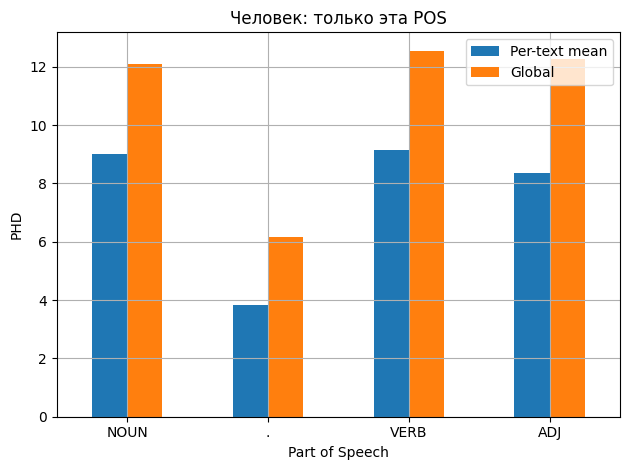

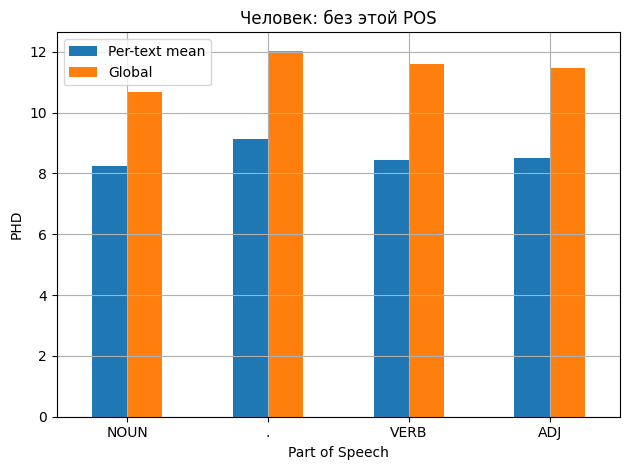

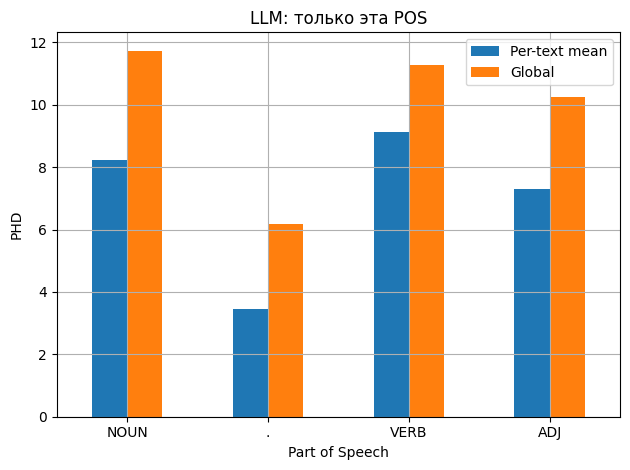

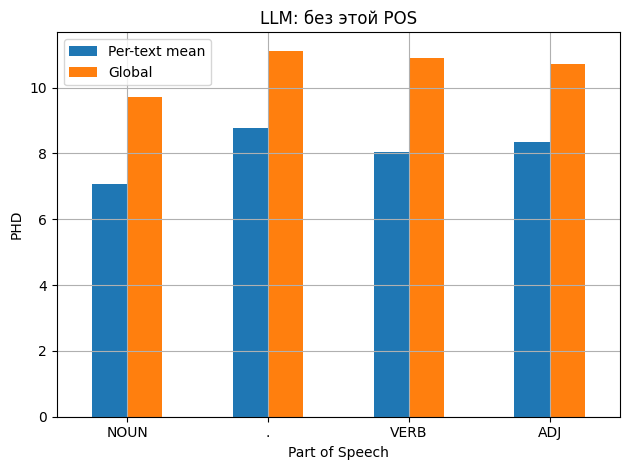

In [14]:
plot_phd_comparison(pos_tags, phd_human_pertext_mean, phd_human_global_pos, "Человек: только эта POS")
plot_phd_comparison(pos_tags, phd_human_pertext_wo_mean, phd_human_global_wo, "Человек: без этой POS")
plot_phd_comparison(pos_tags, phd_llm_pertext_mean, phd_llm_global_pos, "LLM: только эта POS")
plot_phd_comparison(pos_tags, phd_llm_pertext_wo_mean, phd_llm_global_wo, "LLM: без этой POS")

In [15]:
print_phd_mle_counts(count_human, "Человек: per-text (только эта POS)")
print_phd_mle_counts(count_human_wo, "Человек: per-text (без этой POS)")
print_phd_mle_counts(count_human_global, "Человек: global (только эта POS)")
print_phd_mle_counts(count_human_global_wo, "Человек: global (без этой POS)")

print_phd_mle_counts(count_llm, "LLM: per-text (только эта POS)")
print_phd_mle_counts(count_llm_wo, "LLM: per-text (без этой POS)")
print_phd_mle_counts(count_llm_global, "LLM: global (только эта POS)")
print_phd_mle_counts(count_llm_global_wo, "LLM: global (без этой POS)")


=== Человек: per-text (только эта POS) ===


,PHD count,MLE count,Total
NOUN,19,5,24
.,1,21,22
VERB,5,16,21
ADJ,4,17,21



=== Человек: per-text (без этой POS) ===


,PHD count,MLE count,Total
.,20,4,24
VERB,20,4,24
ADJ,20,4,24
NOUN,17,6,23



=== Человек: global (только эта POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1



=== Человек: global (без этой POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1



=== LLM: per-text (только эта POS) ===


,PHD count,MLE count,Total
NOUN,18,6,24
.,2,20,22
ADJ,6,15,21
VERB,8,12,20



=== LLM: per-text (без этой POS) ===


,PHD count,MLE count,Total
NOUN,17,7,24
.,22,2,24
VERB,22,2,24
ADJ,22,2,24



=== LLM: global (только эта POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1



=== LLM: global (без этой POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1


In [17]:
def plot_phd_boxplots(pos2phd_all, title):
    """
    Строит boxplot для PHD по каждой POS.

    Аргументы:
    - pos2phd_all: словарь {pos_tag: [список PHD по текстам]}
    - title: заголовок графика
    """
    pos_tags = list(pos2phd_all.keys())
    data = [pos2phd_all[pos] for pos in pos_tags]

    data = [[x for x in lst if x >= 0 and x <= 100] for lst in data]

    plt.figure(figsize=(8, 5))
    plt.boxplot(data, labels=pos_tags, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(title)
    plt.ylabel("PHD")
    plt.xlabel("Part of Speech. Модель Qwen1.5B")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

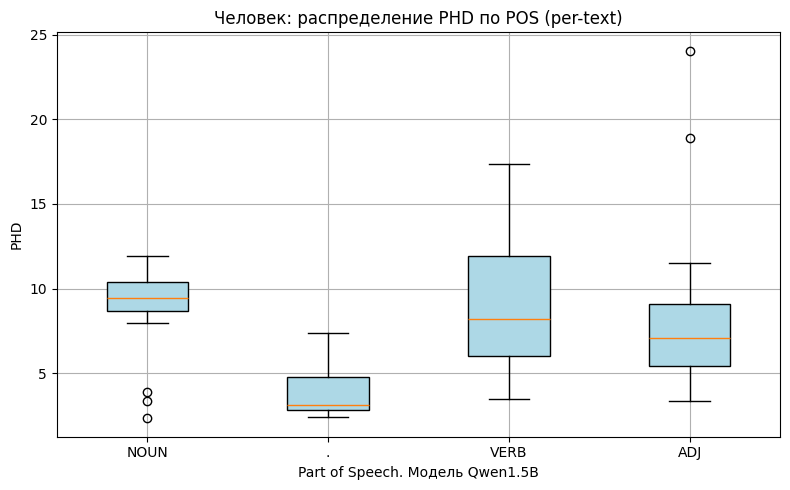

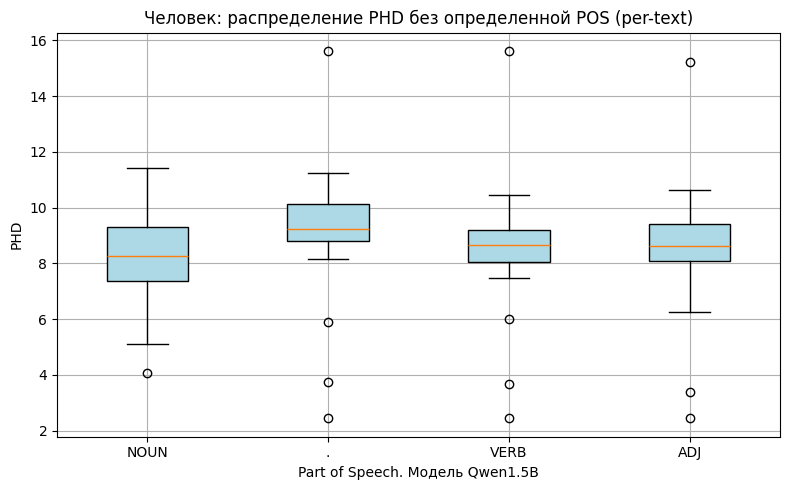

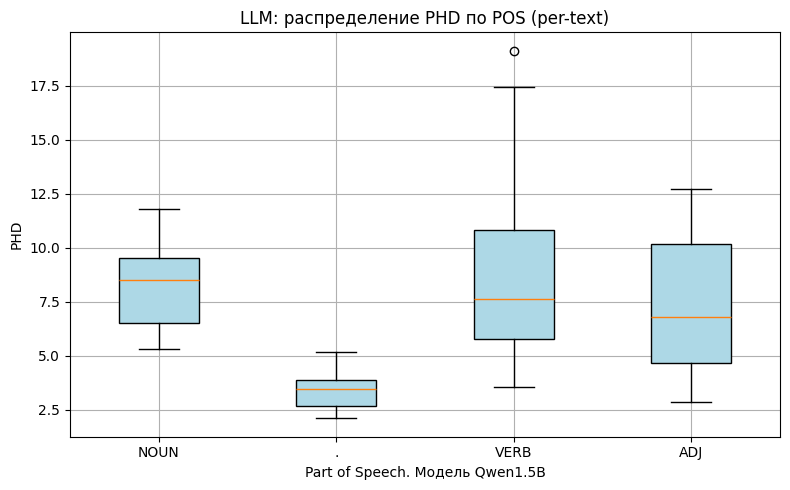

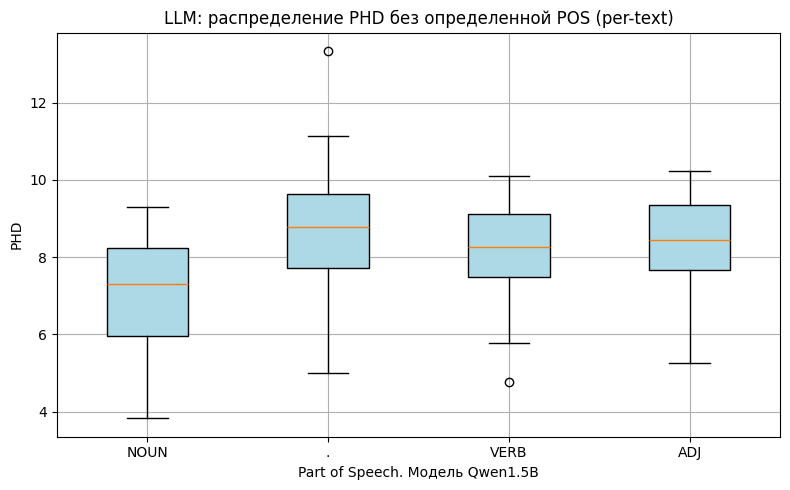

In [18]:
plot_phd_boxplots(phd_human_all, "Человек: распределение PHD по POS (per-text)")
plot_phd_boxplots(phd_human_all_wo, "Человек: распределение PHD без определенной POS (per-text)")
plot_phd_boxplots(phd_llm_all, "LLM: распределение PHD по POS (per-text)")
plot_phd_boxplots(phd_llm_all_wo, "LLM: распределение PHD без определенной POS (per-text)")

In [25]:
def plot_phd_boxplots_compare_human_llm(phd_human_all, phd_llm_all, title, pos_tags):
    """
    Строит boxplot сравнения PHD между Human и LLM для каждой POS с разными цветами.

    Аргументы:
    - phd_human_all: словарь {pos_tag: [PHD-значения]} для человека
    - phd_llm_all: словарь {pos_tag: [PHD-значения]} для LLM
    - title: заголовок графика
    - pos_tags: список POS, которые рисовать
    """
    data = []
    colors = []
    labels = []

    for pos in pos_tags:
        # Фильтруем выбросы
        human_vals = [x for x in phd_human_all.get(pos, []) if 0 <= x <= 100]
        llm_vals = [x for x in phd_llm_all.get(pos, []) if 0 <= x <= 100]

        data.extend([human_vals, llm_vals])
        colors.extend(['lightblue', 'lightsalmon'])
        labels.extend([f"{pos}\nHuman", f"{pos}\nLLM"])

    plt.figure(figsize=(max(10, len(pos_tags)*1.5), 6))
    box = plt.boxplot(data, labels=labels, patch_artist=True)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(title)
    plt.ylabel("PHD")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

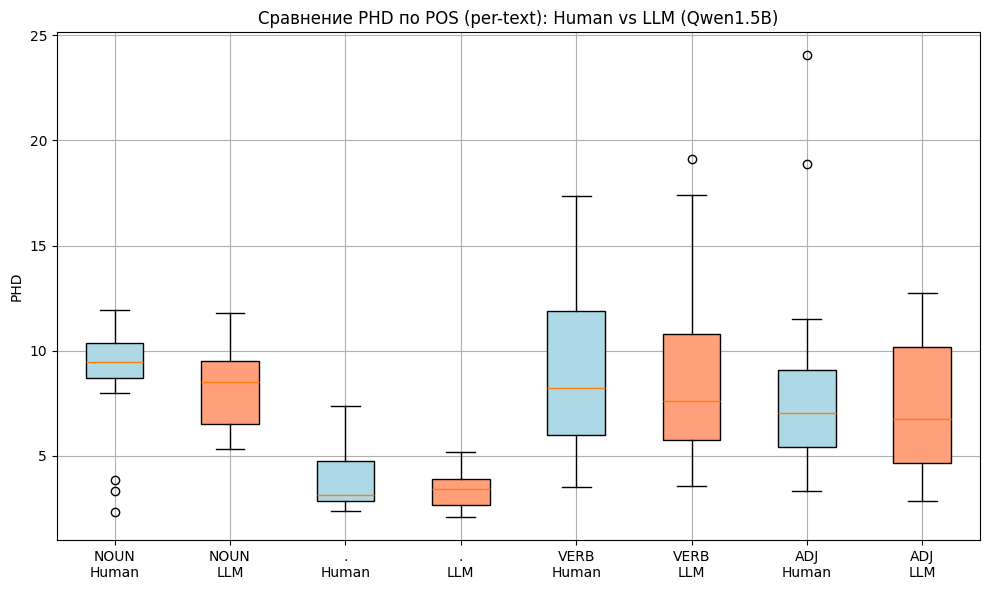

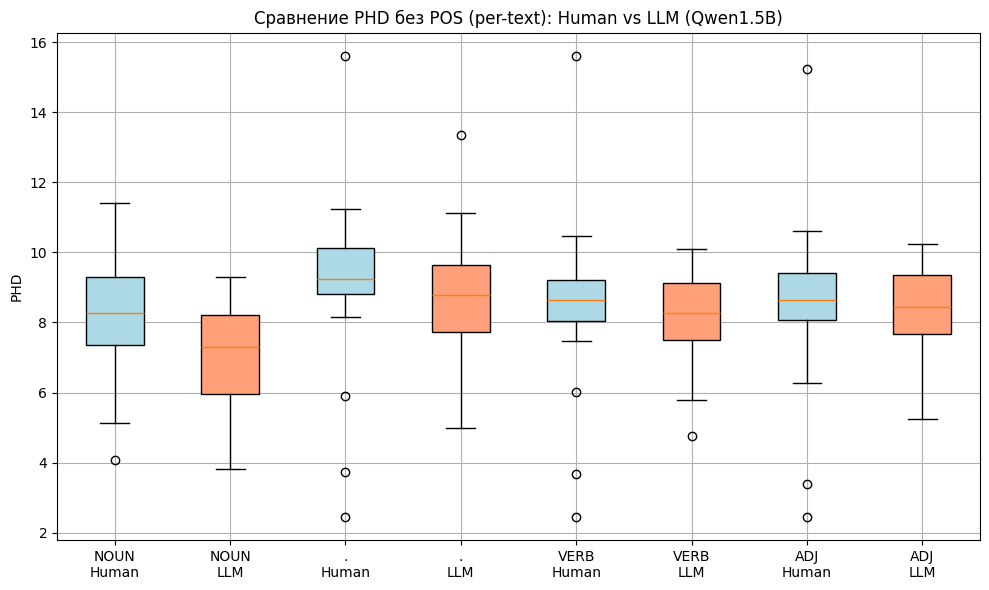

In [26]:
plot_phd_boxplots_compare_human_llm(
    phd_human_all, phd_llm_all,
    "Сравнение PHD по POS (per-text): Human vs LLM (Qwen1.5B)",
    pos_tags
)

plot_phd_boxplots_compare_human_llm(
    phd_human_all_wo, phd_llm_all_wo,
    "Сравнение PHD без POS (per-text): Human vs LLM (Qwen1.5B)",
    pos_tags
)


In [31]:
np.savez("/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week/phd_results_qwen.npz",
    phd_llm_global_pos=phd_llm_global_pos,
    count_llm_global=count_llm_global,
    phd_llm_global_wo=phd_llm_global_wo,
    count_llm_global_wo=count_llm_global_wo,
    phd_llm_all=phd_llm_all,
    phd_llm_pertext_mean=phd_llm_pertext_mean,
    count_llm=count_llm,
    phd_llm_all_wo=phd_llm_all_wo,
    phd_llm_pertext_wo_mean=phd_llm_pertext_wo_mean,
    count_llm_wo=count_llm_wo,

    phd_human_global_pos=phd_human_global_pos,
    count_human_global=count_human_global,
    phd_human_global_wo=phd_human_global_wo,
    count_human_global_wo=count_human_global_wo,
    phd_human_all=phd_human_all,
    phd_human_pertext_mean=phd_human_pertext_mean,
    count_human=count_human,
    phd_human_all_wo=phd_human_all_wo,
    phd_human_pertext_wo_mean=phd_human_pertext_wo_mean,
    count_human_wo=count_human_wo
)